# Advisory report
___
<pre>Teamname    : Submission Impossible 💥  
Group nr    : 32 - Company C  
Students    : {Andrei Dragomir, Ece Doganer, Márk Kerekes, Ariana Vargas Pastor}  
Student nrs : {2669304,         2552855,     2696796,      2710153}  </pre>
___

#### Structure of the project:
1. Data Exploration
- Data visualisation
- Comparisons of our company's distributions as opposed to the general population
- Hiree percentages based on gender, age, nationality and sports

2. Modelling
- Model M1: Neural Network with single hidden layer and no drop-out
    - Only use 4 out of the 8 given indicators
    - Optional: Using a clustering algorithm based on all indicators prior to the deployment of the classification model
- Model M2: Predictive model based on any indicators
    - Does the model perform better than M1?
    - Explanation of the training and testing methods
    - Explanation of the choice of indicators
- Model M3: Model based only on the given descriptors (age, nationality, gender and sports)
    - Evaluate model
    - Discuss whether using this model is ethical or not
    
`IMPORTANT DECISIONS: Ratio of training/test data; Model selection; Hyperparameter optimization`
    
3. Evaluation and advice
- Use _accuracy_ to test predictive models
- Analyse one of our models (suggesting M2)
    - test different feature combinations that result in the best accuracy rate
- Provide advice for the HR department
    - Should the model be used?
    - How should the model be used?
    - What future evaluations and calibrations needed in the future?
    - Discuss potential risks imposed by the usage of this model



## 0. Importing the data set and libraries required

In [18]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import statistics
from scipy.stats import norm
from sklearn import preprocessing
from turtle import title
from enum import unique

#Loading dataset and checking for any possible NaN values
recruitmentData = pd.read_csv (r'recruitmentdataset-2022-1.3.csv')
# print(recruitmentData.isnull().values.any())

#print(recruitmentData)

## 1. Data Exploration

### 1.1 Data visualisation

To begin with, in this chapter we will present the distributions of the general data set:

We start of by visualising the distribution of the descriptors (gender, age, nationality and sport).

### 1.2 Data visualisation

In the section we will compare the distribution of descriptors for hirees of company C and the rest of the hiree population

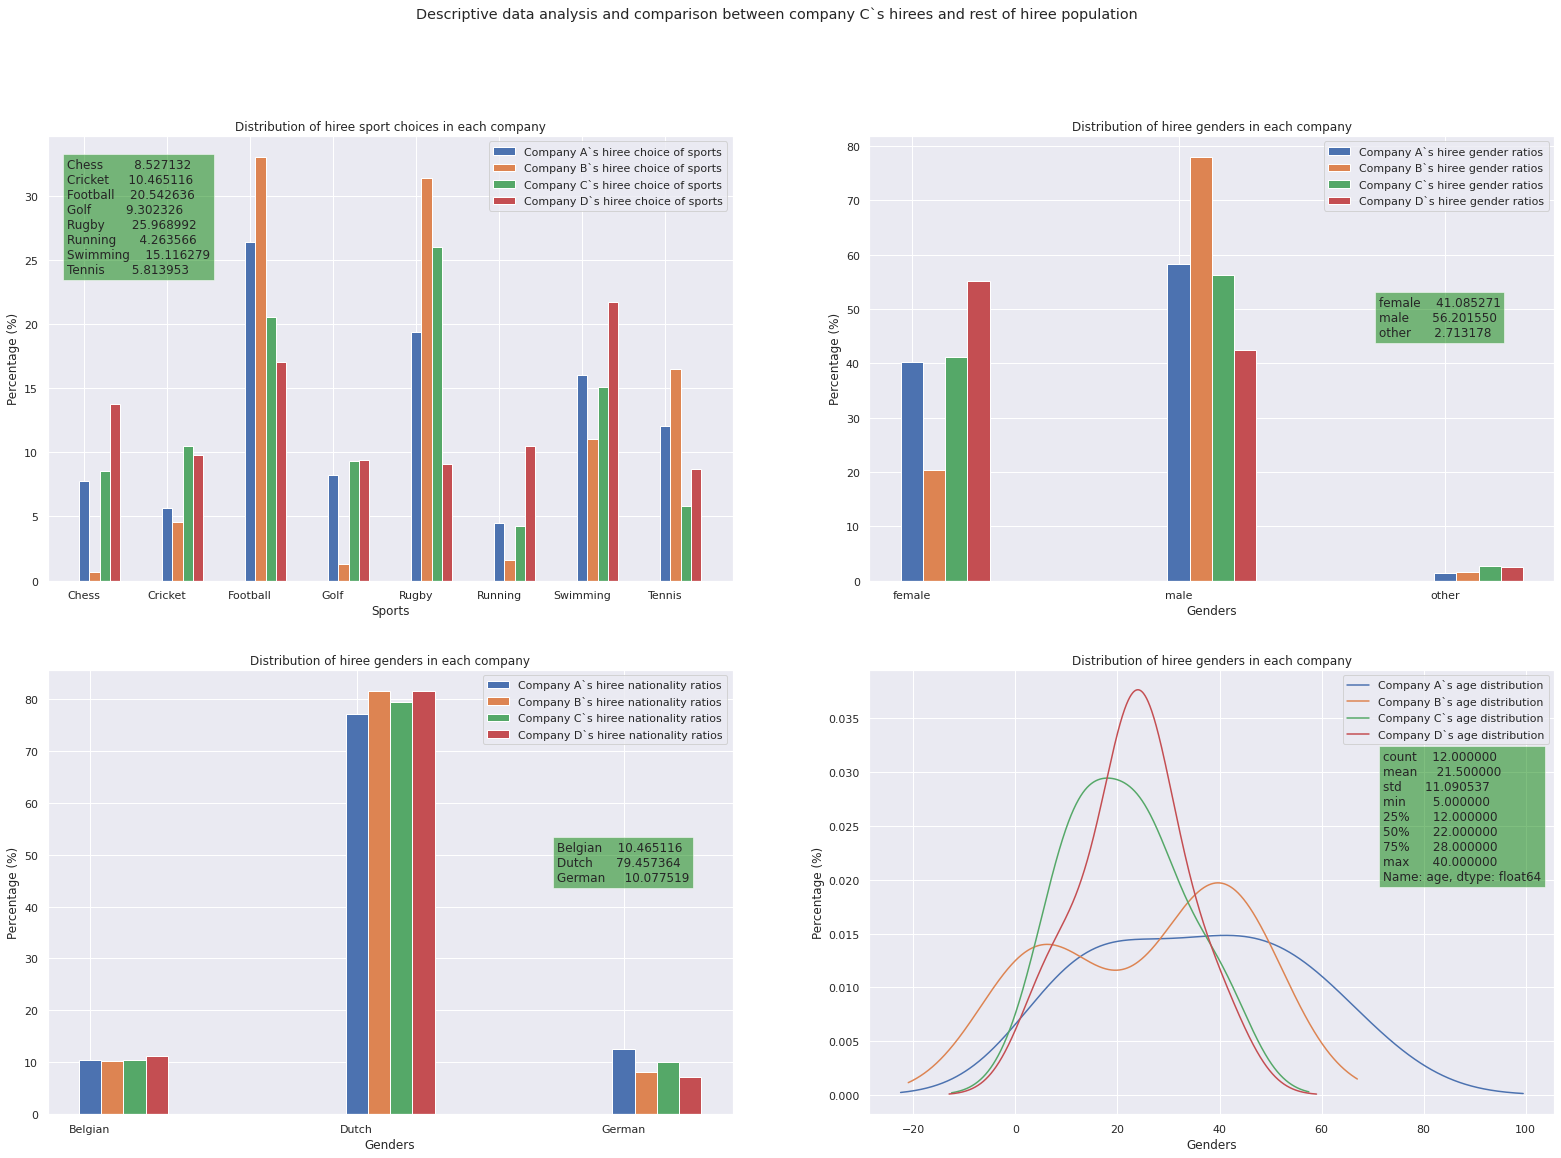

In [134]:
#Parameters used in plot creation

numberOfGenders = recruitmentData['gender'].unique().size
numberOfNationalities = recruitmentData['nationality'].unique().size
numberOfSports = recruitmentData['sport'].unique().size

fig, axs = plt.subplots(2,2)
fig.suptitle('Descriptive data analysis and comparison between company C`s hirees and rest of hiree population')
fig.set_figwidth(27)
fig.set_figheight(18)

#First Plot
XSportsAxis = np.arange(numberOfSports)

for idx, x in enumerate(recruitmentData['company'].unique()):
    sportFrame = recruitmentData.query("decision and company == '" + str(x) + "'")['sport']
    normalizedSportCounts = sportFrame.value_counts().sort_index().divide(sportFrame.count()).multiply(100)
    if (x == 'C'): axs[0, 0].text(-0.2, 24, normalizedSportCounts.to_string(), bbox=dict(facecolor='green', alpha=0.5))
    axs[0, 0].bar(XSportsAxis + idx/numberOfSports, normalizedSportCounts, width= 1/numberOfSports, label='Company ' + str(x) + '`s hiree choice of sports')

axs[0, 0].set_xticks(XSportsAxis)
axs[0, 0].set_xticklabels(recruitmentData['sport'].sort_values().unique().tolist())
axs[0, 0].set_xlabel('Sports')
axs[0, 0].set_ylabel('Percentage (%)')
axs[0, 0].set_title('Distribution of hiree sport choices in each company')
axs[0, 0].legend()

#Second Plot
XGendersAxis = np.arange(numberOfGenders)
for idx, x in enumerate(recruitmentData['company'].unique()):
    genderColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['gender']
    normalizedGenderCounts = genderColumn.value_counts().sort_index().divide(genderColumn.count()).multiply(100)
    if (x == 'C'): axs[0, 1].text(1.75, 45, normalizedGenderCounts.to_string(), bbox=dict(facecolor='green', alpha=0.5))
    axs[0, 1].bar(XGendersAxis + idx/(numberOfGenders * 4), normalizedGenderCounts, width= 1/(numberOfGenders * 4), label='Company ' + str(x) + '`s hiree gender ratios')

axs[0, 1].set_xticks(XGendersAxis)
axs[0, 1].set_xticklabels(recruitmentData['gender'].sort_values().unique().tolist())
axs[0, 1].set_xlabel('Genders')
axs[0, 1].set_ylabel('Percentage (%)')
axs[0, 1].set_title('Distribution of hiree genders in each company')
axs[0, 1].legend()

#Third Plot
XNationalitiesAxis = np.arange(numberOfNationalities)
for idx, x in enumerate(recruitmentData['company'].unique()):
    nationalityColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['nationality']
    normalizedNationalityCounts = nationalityColumn.value_counts().sort_index().divide(nationalityColumn.count()).multiply(100)
    if (x == 'C'): axs[1, 0].text(1.75, 45, normalizedNationalityCounts.to_string(), bbox=dict(facecolor='green', alpha=0.5))
    axs[1, 0].bar(XGendersAxis + idx/(numberOfNationalities * 4), normalizedNationalityCounts, width= 1/(numberOfNationalities * 4), label='Company ' + str(x) + '`s hiree nationality ratios')

axs[1, 0].set_xticks(XNationalitiesAxis)
axs[1, 0].set_xticklabels(recruitmentData['nationality'].sort_values().unique().tolist())
axs[1, 0].set_xlabel('Genders')
axs[1, 0].set_ylabel('Percentage (%)')
axs[1, 0].set_title('Distribution of hiree genders in each company')
axs[1, 0].legend()

#Fourth Plot
for idx, x in enumerate(recruitmentData['company'].unique()):
    ageColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['age'].value_counts()
    #TODO pick the range of the ageColumn.describe() to be from 1 to 7
    if (x == 'C'): axs[1, 1].text(72, 0.02, str(ageColumn.describe()), bbox=dict(facecolor='green', alpha=0.5))
    axs[1, 1] = ageColumn.plot(kind='density', label='Company ' + str(x) + '`s age distribution')
axs[1, 1].set_xlabel('Genders')
axs[1, 1].set_ylabel('Percentage (%)')
axs[1, 1].set_title('Distribution of hiree genders in each company')
axs[1, 1].legend()
